In [1]:
from BreakageClassifier.code.run import process_issue, pipeline
from BreakageClassifier.code import run as features
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from BreakageClassifier.code.graph.database import Database

import random


from dotenv import load_dotenv, find_dotenv
load_dotenv()
DOTENV_PATH = find_dotenv()
DIR = Path(DOTENV_PATH).parent

# CRAWL_OUT_DIR_EASYLIST = DIR.joinpath("crawl-out/easylist/datadir-dd1d84b6414e12f7b8af4dc010d5bfac4b0f123c/")
CRAWL_OUT_DIR_EASYLIST = DIR.joinpath("crawl-out/easylist/datadir-27-5-2023-with-query")

CRAWL_OUT_DIR_UBLOCK = DIR.joinpath("crawl-out/ublock/datadir-27-5-2023-with-query-utc")

SALIENCY_MODEL_PATH = DIR.joinpath("../WebModelGen/block_classifier/pretrained-models/model-0.joblib").resolve()

class EASYLIST:
    CRAWL_DIR = CRAWL_OUT_DIR_EASYLIST
    DB_PATH = CRAWL_OUT_DIR_EASYLIST.joinpath('crawl-data.sqlite')
    EXP_PATH = CRAWL_OUT_DIR_EASYLIST.joinpath('experiments.csv')
    FILTERLISTS_DIR = DIR.joinpath("forums-out/easylist/filterlists")
    OUTPUT_DIR = DIR.joinpath("features-out/easylist/").joinpath(CRAWL_OUT_DIR_EASYLIST.name)
    FEATURES_DIR = DIR / "features-out" /  "easylist" / "datadir-30-05-23-full"
    
class UBLOCK:
    CRAWL_DIR = CRAWL_OUT_DIR_UBLOCK
    DB_PATH = CRAWL_OUT_DIR_UBLOCK.joinpath('crawl-data.sqlite')
    EXP_PATH = CRAWL_OUT_DIR_UBLOCK.joinpath('experiments.csv')
    FILTERLISTS_DIR = DIR.joinpath("forums-out/ublock/filterlists")
    OUTPUT_DIR = DIR.joinpath("features-out/ublock/").joinpath(CRAWL_OUT_DIR_UBLOCK.name)
    FEATURES_DIR = DIR /"features-out" / "ublock" /  "datadir-30-05-23-full"

random.seed(102)

In [5]:
import pandas as pd

def concat_two_dfs(df1, df2):
    return pd.concat([df1, df2], axis=0, ignore_index=True)


df_edits = concat_two_dfs(pd.read_csv("./features-out/adguard/adguard-full-3/edits.csv"), pd.read_csv("./features-out/adguard/adguard-full-4/edits.csv"))
df_log = concat_two_dfs(pd.read_csv("./features-out/adguard/adguard-full-3/log.csv"), pd.read_csv("./features-out/adguard/adguard-full-4/log.csv"))
df_nodes = concat_two_dfs(pd.read_csv("./features-out/adguard/adguard-full-3/nodes.csv"), pd.read_csv("./features-out/adguard/adguard-full-4/nodes.csv"))
df_edges = concat_two_dfs(pd.read_csv("./features-out/adguard/adguard-full-3/edges.csv"), pd.read_csv("./features-out/adguard/adguard-full-4/edges.csv"))

df_edits.to_csv("./features-out/adguard/adguard-final/edits.csv", index=False)
df_log.to_csv("./features-out/adguard/adguard-final/log.csv", index=False)
df_nodes.to_csv("./features-out/adguard/adguard-final/nodes.csv", index=False)
df_edges.to_csv("./features-out/adguard/adguard-final/edges.csv", index=False)


In [10]:
df_log.broken_subtree_count.value_counts()

0     145
1     107
2      65
3      55
4      43
5      23
7      17
9      14
6      13
8      10
10      8
11      7
14      6
12      5
20      4
16      3
18      2
13      2
19      1
26      1
45      1
27      1
36      1
22      1
33      1
31      1
21      1
46      1
35      1
94      1
17      1
Name: broken_subtree_count, dtype: int64

# Process one issue:

In [3]:
print(f"Loading issues from {EASYLIST.CRAWL_DIR}")
with Database(EASYLIST.DB_PATH, EASYLIST.EXP_PATH) as database:
    issues = database.sites_visits()
    print(f"Number of issues: {len(issues)}")
    
    issue = issues.iloc[random.randint(0, len(issues)-1)]
    print(issue)

    print("Testing features")
    _edits, issue_log, nodes_df, edges_df = process_issue(issue, database)
    
    # df_dom = database.get_dom_from_visit_id(issue.visit_id_a)
    
    # print(df_dom[df_dom.saliency == 1.0])

Loading issues from /home/saiid/summer22-SaiidHajj/Experiments/crawl-out/easylist/datadir-27-5-2023-with-query
Number of issues: 49
visit_id_b                                     8806563340214769.0
browser_id_b                                         2674795419.0
visit_id_u                                     4956138980509522.0
browser_id_u                                         2674795419.0
visit_id_a                                     1562195087301110.0
browser_id_a                                         2674795419.0
error                                                       False
issue_id                                                    46855
site_url        https://archive.org/details/sim_journal-of-adv...
Name: https://archive.org/details/sim_journal-of-advertising_1986_15_1, dtype: object
Testing features
INFO ISSUE 46855

DEBUG Building no-to-fixed diff-tree

DEBUG no-to-fixed diff-tree completed in 24 s

DEBUG Building fixed-to-broken diff-tree

DEBUG fixed-to-broken diff

# Labels Experiments

In [4]:
print(f"Loading issues from {UBLOCK.CRAWL_DIR}")
with Database(UBLOCK.DB_PATH, UBLOCK.EXP_PATH) as database:
    issues = database.sites_visits()
    print(f"Number of issues: {len(issues)}")
    
    issue = issues.iloc[random.randint(0, len(issues)-1)]
    print(issue)

    print("Testing features")
    _, df_after, df_nodes_after, df_edges_after = features.build_graph(database, issue.visit_id_a, issue.site_url)
    salient_nodes = df_after[df_after.saliency == 1.0]
    
    print(f"df_after. {len(df_after)} nodes.")
    
    df_unfiltered = features.build_graph(database, issue.visit_id_u, issue.site_url)
    
    print(f"df_unfiltered. {len(df_unfiltered)} nodes.") 
    
    df_broken = features.build_graph(database, issue.visit_id_b, issue.site_url)
    
    print(f"df_broken. {len(df_broken)} nodes.") 
    
    print("Number of salient nodes: ", len(salient_nodes))
    
    (*_, salient_nodes, no_to_fixed_common, no_to_fixed_diff, no_to_fixed_nodes, no_to_fixed_edges) = features.process_differential_experiment(
            issue.browser_id_u,(issue.visit_id_u, issue.visit_id_a), database, issue.site_url, salient_nodes
        )
    
    print(f"u to a done. {len(no_to_fixed_diff[no_to_fixed_diff['is_root'] == True])} subtrees. {len(no_to_fixed_diff)} nodes.")
    
    *_, fixed_to_broken_diff, fixed_to_broken_nodes, fixed_to_broken_edges = features.process_differential_experiment(
            issue.browser_id_u, (issue.visit_id_a, issue.visit_id_b), database, issue.site_url, salient_nodes
        )
    
    print(f"a to b done. {len(fixed_to_broken_diff[fixed_to_broken_diff['is_root'] == True])} subtrees. {len(fixed_to_broken_diff)} nodes.")
    
    *_, no_to_broken_diff, no_to_broken_nodes, no_to_broken_edges = features.process_differential_experiment(
            issue.browser_id_u, (issue.visit_id_u, issue.visit_id_b), database, issue.site_url, salient_nodes
        )
    
    print(f"u to b done. {len(no_to_broken_diff[no_to_broken_diff['is_root'] == True])} subtrees. {len(no_to_broken_diff)} nodes.")

Loading issues from /home/saiid/summer22-SaiidHajj/Experiments/crawl-out/ublock/datadir-27-5-2023-with-query-utc
Number of issues: 203
visit_id_b                                     1219330645448462.0
browser_id_b                                          526726591.0
visit_id_u                                     8551897169568031.0
browser_id_u                                          526726591.0
visit_id_a                                     5626242413627040.0
browser_id_a                                          526726591.0
error                                                       False
issue_id                                                    11557
site_url        https://www.scan-manga.com/lecture-en-ligne/Th...
Name: https://www.scan-manga.com/lecture-en-ligne/The-Lazy-Prince-Becomes-a-Genius-Chapitre-39-FR_222582.html, dtype: object
Testing features
!no interactions
df_after. 327 nodes.
!no interactions
df_unfiltered. 4 nodes.
!no interactions
df_broken. 4 nodes.
Number of sal

# Segmentation Experiments

In [4]:
edits_df = pd.read_csv(str(UBLOCK.FATURES_DIR / "edits.csv"))
edit_roots_df = edits_df[edits_df['is_root'] == True]
print(edits_df.columns)

Index(['new_attr_class', 'new_attr_id', 'new_attr_src', 'new_attr', 'new_bid',
       'new_id', 'new_parent', 'new_te', 'new_tl', 'new_vid', 'new_vc',
       'saliency', 'party', 'is_root', 'prev_bid', 'prev_vid', 'prev_id',
       'tag', 'type', 'prev_attr', 'prev_vc', 'prev_parent', 'prev_te',
       'prev_tl', 'block', 'domain', 'top_level_domain', 'prev_attr_id',
       'prev_attr_class', 'prev_attr_src', 'edited', 'removed', 'added',
       'processed', 'is_breaking', 'origin', 'flipped', 'issue'],
      dtype='object')


In [11]:

stats = []


for _, root in tqdm(edit_roots_df.iterrows(), total=len(edit_roots_df)):
    _children = edits_df[
        (
            (edits_df["prev_vid"] == root.prev_vid)
            & (edits_df["prev_te"] > root.prev_te)
            & (edits_df["prev_tl"] < root.prev_tl)
        )
        | (
            (edits_df["new_vid"] == root.new_vid)
            & (edits_df["new_te"] > root.new_te)
            & (edits_df["new_tl"] < root.new_tl)
        )
    ]
    
    max_depth = 0
    
    for _, child in _children.iterrows():
        
        parent = child.prev_parent if child.prev_parent else child.new_parent
        root_id = root.prev_id if root.prev_id else root.new_id
        
        depth = 0
        while parent and parent != root_id:
            
            pp = _children[_children['prev_id'] == parent]
            if len(pp):
                parent = pp.iloc[0]
                parent = parent.prev_parent if parent.prev_parent else parent.new_parent
                depth+= 1
                continue
            pn = _children[_children['new_id'] == parent]
            if len(pn):
                parent = pn.iloc[0]
                parent = parent.prev_parent if parent.prev_parent else parent.new_parent
                depth+= 1
                continue
            
            if not len(pp) and not len(pn):
                break
            
        if depth > max_depth:
            max_depth = depth
    
    stats.append({
        'n_nodes': len(_children) +1 ,
        'is_breaking': root.is_breaking,
        'depth': max_depth
    })
    
    
stats = pd.DataFrame(stats)

100%|██████████| 3133/3133 [07:43<00:00,  6.76it/s] 


Number of subtrees with one node: 209 (49 %)
Number of subtrees with 2 nodes: 78 (18 %)
Number of subtrees with 3 nodes: 40 (9 %)


Text(0.5, 1.0, 'Distribution of the subtree sizes')

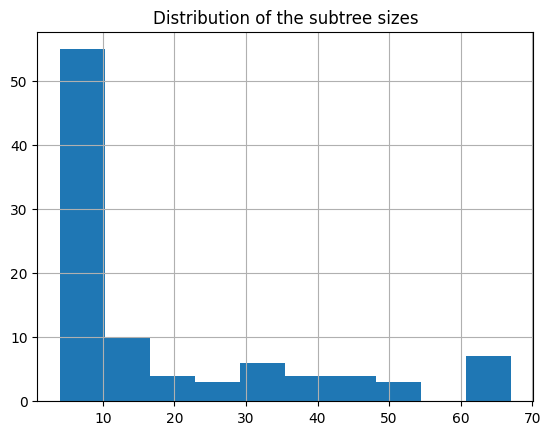

In [36]:
print(f"Number of subtrees with one node: {len(stats[stats.n_nodes == 1])} ({int(len(stats[stats.n_nodes == 1])/len(stats) * 100)} %)")
print(f"Number of subtrees with 2 nodes: {len(stats[stats.n_nodes == 2])} ({int(len(stats[stats.n_nodes == 2])/len(stats) * 100)} %)")
print(f"Number of subtrees with 3 nodes: {len(stats[stats.n_nodes == 3])} ({int(len(stats[stats.n_nodes == 3])/len(stats) * 100)} %)")


stats[stats.n_nodes >3 ].n_nodes.hist()
plt.title("Distribution of the subtree sizes")

Number of subtrees with depth 1: 2554 (81 %)
Number of subtrees with depth 2: 155 (4 %)
Number of subtrees with depth 3: 118 (3 %)


Text(0.5, 1.0, 'Distribution of the subtree depths')

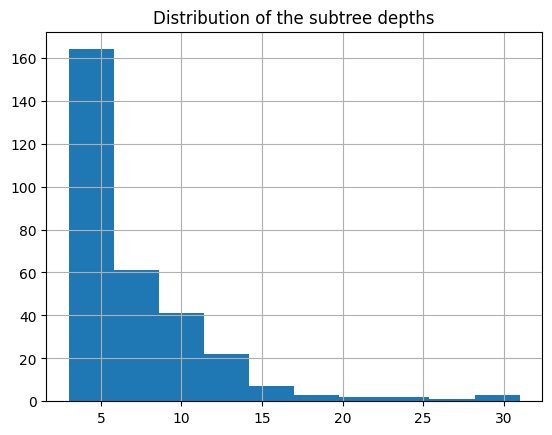

In [13]:
print(f"Number of subtrees with depth 1: {len(stats[stats.depth == 0])} ({int(len(stats[stats.depth == 0])/len(stats) * 100)} %)")
print(f"Number of subtrees with depth 2: {len(stats[stats.depth == 1])} ({int(len(stats[stats.depth == 1])/len(stats) * 100)} %)")
print(f"Number of subtrees with depth 3: {len(stats[stats.depth == 2])} ({int(len(stats[stats.depth == 2])/len(stats) * 100)} %)")


stats[stats.depth >2 ].depth.hist()
plt.title("Distribution of the subtree depths")

## Experiment different label strategies

In [5]:
_edits = features.dl.label_alterations2(
            no_to_fixed_common,
            no_to_fixed_diff,
            fixed_to_broken_diff,
            no_to_broken_diff,
        )

print("Edit subtrees: ")
print(_edits.is_breaking.value_counts())
print(_edits.is_breaking.value_counts())
print("Number of subtrees that are fixing but removed: ", len(_edits[(_edits.removed == True) & (_edits.is_breaking == -1)]))

/home/saiid/miniconda3/envs/openwpm/lib/python3.10/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


Edit subtrees: 
 0    320
-1    103
Name: is_breaking, dtype: int64
 0    320
-1    103
Name: is_breaking, dtype: int64
Number of subtrees that are fixing but removed:  103


/home/saiid/miniconda3/envs/openwpm/lib/python3.10/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


# Saliency Experiments

In [9]:
def get_saliencies(db_path, exp_path):
    with Database(db_path, exp_path) as database:
        issues = database.sites_visits()
        
        saliency_values = {}
        saliencies_ratios = []
        saliencies_nums = []
        element_nums = []
        
        for _, issue in tqdm(issues.iterrows(), total = len(issues)):
            df_dom = database.get_dom_from_visit_id(issue.visit_id_a)
            
            sal_vals = df_dom.saliency.value_counts().to_dict()
            saliencies_nums.append(sal_vals.get(1.0, 0))
            element_nums.append(sum(sal_vals.values()))
            
            saliencies_ratios.append(saliencies_nums[-1]/ element_nums[-1] if element_nums[-1] else 1)
            
            for key in sal_vals:
                
                if key not in saliency_values:
                    saliency_values[key] = 0
                
                saliency_values[key] += sal_vals[key]
                
    return issues, saliency_values, element_nums, saliencies_nums, saliencies_ratios

Saliencies = namedtuple("Saliencies", "issues saliency_values element_nums saliencies_nums saliencies_ratios")

easylist_saliencies = Saliencies(*get_saliencies(EASYLIST.DB_PATH, EASYLIST.EXP_PATH))
ublock_saliencies = Saliencies(*get_saliencies(UBLOCK.DB_PATH, UBLOCK.EXP_PATH))


100%|██████████| 242/242 [01:03<00:00,  3.83it/s]


Easylist
{0.0: 1336, 1.0: 461}
0 issues have no elements
11 issues have no salient elements
1 issues where all elements are salient
---------------
Ublock
{0.0: 5662, 1.0: 1845}
15 issues have no elements
56 issues have no salient elements
21 issues where all elements are salient
---------------


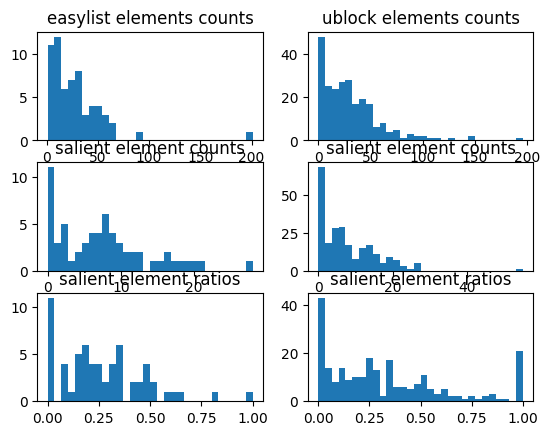

In [10]:
print("Easylist")
print(easylist_saliencies.saliency_values)
print(f"{len(list(filter(lambda x: x == 0, easylist_saliencies.element_nums)))} issues have no elements")
print(f"{len(list(filter(lambda x: x == 0, easylist_saliencies.saliencies_nums)))} issues have no salient elements")
print(f"{len(list(filter(lambda x: x[0] == x[1], zip(easylist_saliencies.saliencies_nums, easylist_saliencies.element_nums))))} issues where all elements are salient")
print("---------------")

print("Ublock")
print(ublock_saliencies.saliency_values)
print(f"{len(list(filter(lambda x: x == 0, ublock_saliencies.element_nums)))} issues have no elements")
print(f"{len(list(filter(lambda x: x == 0, ublock_saliencies.saliencies_nums)))} issues have no salient elements")
print(f"{len(list(filter(lambda x: x[0] == x[1], zip(ublock_saliencies.saliencies_nums, ublock_saliencies.element_nums))))} issues where all elements are salient")
print("---------------")


import matplotlib.pyplot as plt

n_bins = 30

plt.subplot(3,2,1)
plt.hist(easylist_saliencies.element_nums, bins=n_bins)
plt.title("easylist elements counts")

plt.subplot(3,2,2)
plt.hist(ublock_saliencies.element_nums, bins=n_bins)
plt.title("ublock elements counts")

plt.subplot(3,2,3)
plt.hist(easylist_saliencies.saliencies_nums, bins=n_bins)
plt.title("salient element counts")

plt.subplot(3,2,4)
plt.hist(ublock_saliencies.saliencies_nums, bins=n_bins)
plt.title("salient element counts")

plt.subplot(3,2,5)
plt.hist(easylist_saliencies.saliencies_ratios, bins=n_bins)
plt.title("salient element ratios")

plt.subplot(3,2,6)
plt.hist(ublock_saliencies.saliencies_ratios, bins=n_bins)
plt.title("salient element ratios")

plt.show()

In [16]:
print("easylist where all elements salient")
print(easylist_saliencies.issues[[x == y for x,y in zip(easylist_saliencies.saliencies_nums, easylist_saliencies.element_nums)]][["issue_id", "site_url"]].values)

print("ublock where all elements salient")
print(ublock_saliencies.issues[[x == y for x,y in zip(ublock_saliencies.saliencies_nums, ublock_saliencies.element_nums)]][["issue_id", "site_url"]].values)

easylist where all elements salient
[[46107 'https://ads-net.org']]
ublock where all elements salient
[[13390
  'http://pages.emails.bbc.com/subscribe/?ocid=ear.bbc.email.we.email-signup']
 [13355 'http://waaw.to/']
 [13390 'https://careers.southwestair.com/']
 [13135 'https://crystalmark.info/en/software/crystaldiskinfo/']
 [11770
  'https://demo2.drivetrain.ai/explore/metrics.Temp_Cohort__Jan__22_?f=&planId=6']
 [11774
  'https://demo2.drivetrain.ai/model/modules/Temp_Cohort__Jan__22_/metrics.Temp_Cohort__Jan__22_']
 [13349 'https://es.wallapop.com/']
 [13398
  'https://eu.tamrieltradecentre.com/pc/Trade/SearchResult?ItemID=211&SortBy=LastSeen&Order=desc']
 [13143
  'https://filmzie.com/content/behind-the-wall?sourceId=613744175971e8001d714cd5']
 [13397 'https://www.adidas.fr/']
 [13135
  'https://www.adweek.com/agencies/new-data-shows-what-marketers-are-looking-for-with-media-agency-relationships/']
 [13341
  'https://www.apkmirror.com/?post_type=app_release&searchtype=app&s=tiktok'

In [17]:
print("easylist where no salient elements")
print(easylist_saliencies.issues[[x == 0 for x in easylist_saliencies.saliencies_nums]][["issue_id", "site_url"]].values)

print("ublock where no salient elements")
print(ublock_saliencies.issues[[x == 0 for x in ublock_saliencies.saliencies_nums]][["issue_id", "site_url"]].values)

easylist where no salient elements
[[46851
  'https://3d-load.net/texture-shaders/exes-and-bows-hugs-and-kisses/']
 [47024 'https://adsys.in']
 [47367 'https://advert-ai.com/']
 [46459 'https://cloud.ad-sys.de']
 [46495 'https://en.calameo.com/read/005393608892f16d8a672']
 [47382 'https://paste.crdroid.net/wJnlvc']
 [46123
  'https://recorder.ro/lectie-de-santaj-in-guvernul-romaniei-cum-se-elibereaza-functii-pentru-membrii-de-partid/']
 [47229 'https://unsplash.com/photos/0KZmRMTbBUc']
 [47253 'https://www.adrunner.io']
 [47370 'https://www.adspipe.com/barracuda-3d-design-tool']
 [47396 'https://www.overclockers.co.uk/']]
ublock where no salient elements
[[13390
  'http://pages.emails.bbc.com/subscribe/?ocid=ear.bbc.email.we.email-signup']
 [13355 'http://waaw.to/']
 [7575 'https://canalplus.com']
 [13390 'https://careers.southwestair.com/']
 [460 'https://cbsnews.com']
 [13135 'https://crystalmark.info/en/software/crystaldiskinfo/']
 [11418
  'https://docs.google.com/document/d/id-of-

In [ ]:
import WebModelGen.block_classifier.classify as saliency_classifier

saliency_classifier.debug_page("https://www.hotstar.com/in/tv/bigg-boss/14455/day-82-in-the-house/1260076768", SALIENCY_MODEL_PATH)

## Feature Extraction
This section details the commands needed to perform feature extraction

In [ ]:
pipeline(
    UBLOCK.DB_PATH,
    UBLOCK.EXP_PATH,
    UBLOCK.CRAWL_DIR.joinpath('content.ldb'),
    UBLOCK.FILTERLISTS_DIR,
    UBLOCK.OUTPUT_DIR
)

## Analysis

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("features-out/ublock/datadir-30-04-2023/features.csv")
df.head(3)

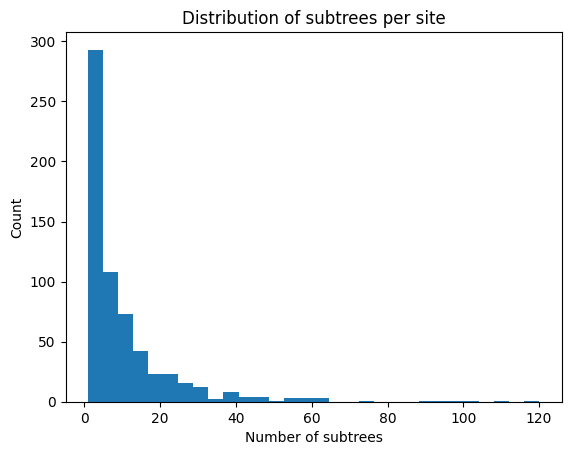

,count
count,625.000000
mean,10.211200
std,14.613181
min,1.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,120.000000


In [61]:
# distribution of subtrees per site

counts = pd.concat([
    df.groupby('prev_vid').size().reset_index().rename(columns={0:'count', 'prev_vid': 'vid'}),
    df.groupby('new_vid').size().reset_index().rename(columns={0:'count', 'new_vid': 'vid'})
    ], axis=0)

_counts = counts['count'].values

plt.hist(_counts, bins=30)
plt.title("Distribution of subtrees per site")
plt.xlabel("Number of subtrees")
plt.ylabel("Count")
plt.show()

counts[['count']].describe()

In [65]:
# distribution of nodes per subtree

n_nodes = df[['n_nodes']]
n_nodes.describe()

,n_nodes
count,6382.000000
mean,17.604826
std,588.248454
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,46650.000000


We have one outlier where we have the whole tree as one subtree (46650 nodes)

In [70]:
# removing the outlier

n_nodes = n_nodes[n_nodes['n_nodes'] != 46650.000000]

n_nodes.describe()

,n_nodes
count,6381.000000
mean,10.296819
std,72.067756
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2179.000000


Number of subtrees with only one node:  4937 77 %
Number of subtrees with 1 < nodes < 50:  1264 19 %
Number of subtrees with 50 <= nodes:  180 2 %


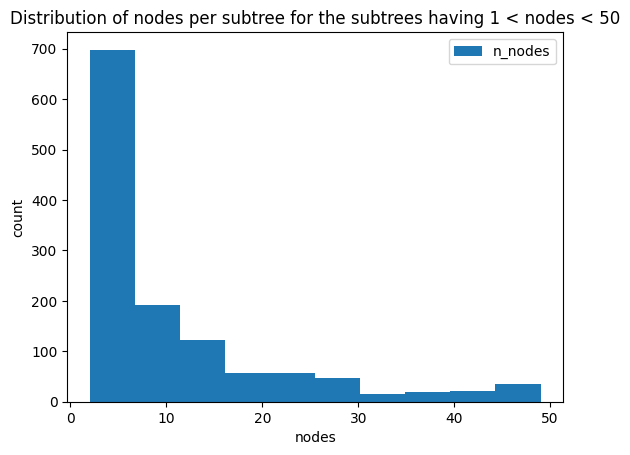

Statistics for subtree for the subtrees having 1 < nodes < 50
           n_nodes
count  1264.000000
mean     10.258703
std      11.176990
min       2.000000
25%       3.000000
50%       5.000000
75%      13.000000
max      49.000000


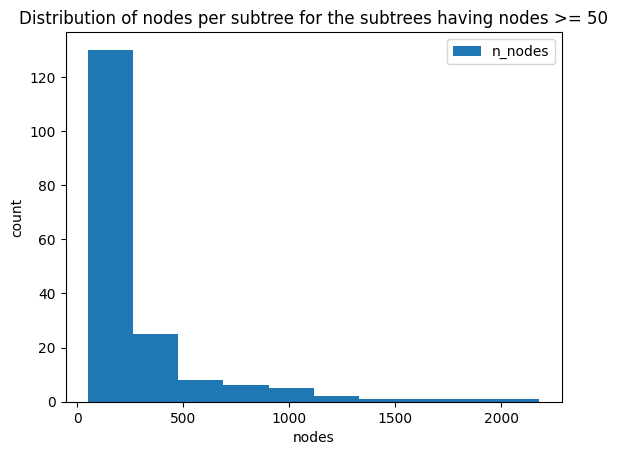

Statistics for subtree for the subtrees having nodes >= 50
           n_nodes
count   180.000000
mean    265.555556
std     341.074890
min      51.000000
25%      71.000000
50%     126.500000
75%     303.000000
max    2179.000000


,n_nodes
count,1264.000000
mean,10.258703
std,11.176990
min,2.000000
25%,3.000000
50%,5.000000
75%,13.000000
max,49.000000


In [100]:
# divide between those that are 1 and others

print("Number of subtrees with only one node: ", len(n_nodes[n_nodes['n_nodes'] == 1]), f"{int(len(n_nodes[n_nodes['n_nodes'] == 1])/ len(n_nodes)*100)} %")

n_nodes_gt_1 = n_nodes[n_nodes['n_nodes'] !=1]

# divide between those under 50 and those above

n_nodes_gt_1_lt_50 = n_nodes_gt_1[n_nodes_gt_1['n_nodes'] < 50]
n_nodes_gt_50 = n_nodes_gt_1[n_nodes_gt_1['n_nodes'] >= 50]


print("Number of subtrees with 1 < nodes < 50: ", len(n_nodes_gt_1_lt_50),  f"{int(len(n_nodes_gt_1_lt_50)/ len(n_nodes)*100)} %")
print("Number of subtrees with 50 <= nodes: ", len(n_nodes_gt_50), f"{int(len(n_nodes_gt_50)/ len(n_nodes)*100)} %")


n_nodes_gt_1_lt_50.plot.hist()
plt.title("Distribution of nodes per subtree for the subtrees having 1 < nodes < 50")
plt.xlabel("nodes")
plt.ylabel("count")
plt.show()

print("Statistics for subtree for the subtrees having 1 < nodes < 50")
print(n_nodes_gt_1_lt_50.describe())


n_nodes_gt_50.plot.hist()
plt.title("Distribution of nodes per subtree for the subtrees having nodes >= 50")
plt.xlabel("nodes")
plt.ylabel("count")
plt.show()

print("Statistics for subtree for the subtrees having nodes >= 50")
print(n_nodes_gt_50.describe())



### Label distribution

<Axes: >

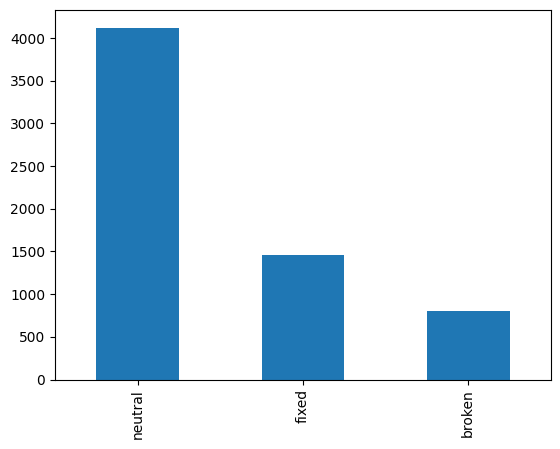

In [117]:
labels = df.is_breaking.values.tolist()

for i, label in enumerate(labels):
    if label == -1:
        labels[i] = 'fixing'
    elif label == 0:
        labels[i] = 'neutral'
    else:
        labels[i] = 'broken'

labels_counts = df.is_breaking.value_counts()
labels_counts.index = ['fixing', 'neutral', 'broken']

labels_counts.plot.bar()

In [ ]:

df_neutral = df[df.is_breaking == 0]
df_broken = df[df.is_breaking == 1] 
df_fixed = df[df.is_breaking == -1]  

df_neutral_counts = pd.concat([
    df_neutral.groupby(['prev_vid']).size().reset_index().rename(columns={0:'count', 'prev_vid': 'vid'}),
    df_neutral.groupby(['new_vid']).size().reset_index().rename(columns={0:'count', 'new_vid': 'vid'})
    ], axis=0)

df_fixed_counts = pd.concat([
    df_fixed.groupby(['prev_vid']).size().reset_index().rename(columns={0:'count', 'prev_vid': 'vid'}),
    df_fixed.groupby(['new_vid']).size().reset_index().rename(columns={0:'count', 'new_vid': 'vid'})
    ], axis=0)

df_broken_counts = pd.concat([
    df_broken.groupby(['prev_vid']).size().reset_index().rename(columns={0:'count', 'prev_vid': 'vid'}),
    df_broken.groupby(['new_vid']).size().reset_index().rename(columns={0:'count', 'new_vid': 'vid'})
    ], axis=0)


df_breaking_counts = pd.merge(df_neutral_counts.rename(columns={'count':'n_neutral'}), df_fixed_counts.rename(columns={"count": 'n_fixed'}), how='outer', on='vid')
df_breaking_counts = pd.merge(df_breaking_counts, df_broken_counts.rename(columns={"count": 'n_broken'}), how='outer', on='vid')

df_breaking_counts[~df_breaking_counts.notnull()] = 0

df_breaking_counts = df_breaking_counts[(df_breaking_counts['n_fixed'] != 0) | (df_breaking_counts['n_broken'] != 0)]

x = df_breaking_counts.n_broken.values.tolist()
y = df_breaking_counts.n_fixed.values.tolist()

print("Number of visits having 0 fixing subtrees: ", len(df_breaking_counts[df_breaking_counts.n_fixed == 0]))
print("Number of visits having 0 broken subtrees: ", len(df_breaking_counts[df_breaking_counts.n_fixed == 0]))


plt.hist2d(x,y ,bins=[30,30])

# Interactions Experiments

In [ ]:
def get_interactions(db_path, exp_path):
    with Database(db_path, exp_path) as database:
        issues = database.sites_visits()
        
        # vals
        interaction_counts = []
        js_counts = []
        http_counts = []
        all_same_logs = []
        
        for _, issue in tqdm(issues.iterrows(), total = len(issues)):
            df_responses = database.get_http_responses(issue.visit_id_a)
            df_javascript = database.get_javascript_events(issue.visit_id_a)
            
            interactions, df_javascript, df_responses = database.get_interaction_logs_all(
                issue.visit_id_a, df_javascript, df_responses
            )
            interaction_counts.append(len(interactions))
            
            _js_counts = df_javascript.groupby("interaction", dropna=True).time_stamp.aggregate("count")
            js_counts.append(_js_counts.values.sum())
            
            _http_counts = df_responses.groupby("interaction", dropna=True).time_stamp.aggregate("count")
            http_counts.append(_http_counts.values.sum())
            
            df_responsesu = database.get_http_responses(issue.visit_id_u)
            df_javascriptu = database.get_javascript_events(issue.visit_id_u)
            _, df_javascriptu, df_responsesu = database.get_interaction_logs_all(
                issue.visit_id_u, df_javascriptu, df_responsesu
            )
            
            df_responsesb = database.get_http_responses(issue.visit_id_b)
            df_javascriptb = database.get_javascript_events(issue.visit_id_b)
            _, df_javascriptb, df_responsesb = database.get_interaction_logs_all(
                issue.visit_id_b, df_javascriptb, df_responsesb
            )
            
            if len(df_javascriptb) == len(df_javascript):
                all_same_logs.append(1)
            else:
                all_same_logs.append(0)
            
            
            
    return pd.DataFrame({
        'issue': issues.issue_id.values,
        'interaction_counts':interaction_counts, 
        'js_counts': js_counts, 
        'http_counts': http_counts, 
        'all_same': all_same_logs })

easylist_interactions = get_interactions(EASYLIST.DB_PATH, EASYLIST.EXP_PATH)
easylist_interactions.to_csv(EASYLIST.FEATURES_DIR / "interactions-stats.csv", index=False)
ublock_interactions = get_interactions(UBLOCK.DB_PATH, UBLOCK.EXP_PATH)
ublock_interactions.to_csv(UBLOCK.FEATURES_DIR / "interactions-stats.csv", index=False)

In [4]:
# loading pre-computed stats
easylist_interactions = pd.read_csv(EASYLIST.FEATURES_DIR / "interactions-stats.csv")
ublock_interactions = pd.read_csv(UBLOCK.FEATURES_DIR / "interactions-stats.csv")

Text(0.5, 1.0, 'Easylist interactions distribution')

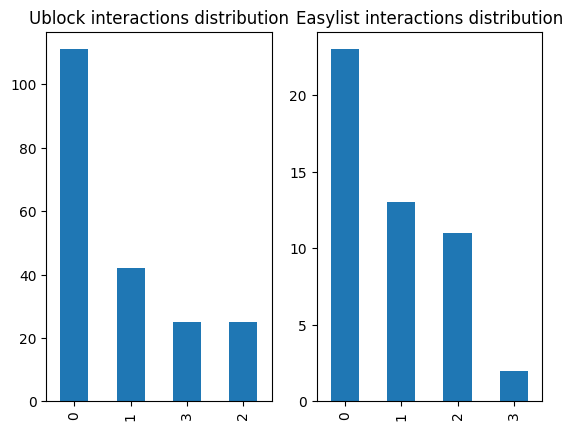

In [18]:
plt.subplot(1,2,1)
ublock_interactions.interaction_counts.value_counts().plot.bar()
plt.title("Ublock interactions distribution")

plt.subplot(1,2,2)
easylist_interactions.interaction_counts.value_counts().plot.bar()
plt.title("Easylist interactions distribution")

Ublock Events 
count    133.000000
mean      61.233083
std      128.126351
min        1.000000
25%        3.000000
50%        9.000000
75%       54.000000
max      917.000000
dtype: float64
count     79.000000
mean      38.493671
std       56.454627
min        1.000000
25%        2.000000
50%        9.000000
75%       53.000000
max      318.000000
dtype: float64
------------
Easylist
count     30.000000
mean      57.666667
std      100.512251
min        1.000000
25%        2.250000
50%       13.500000
75%       80.250000
max      471.000000
dtype: float64
count    12.00000
mean     14.75000
std      22.07477
min       2.00000
25%       3.50000
50%       5.00000
75%      13.50000
max      77.00000
dtype: float64


Text(0.5, 1.0, 'Easylist interactions distribution')

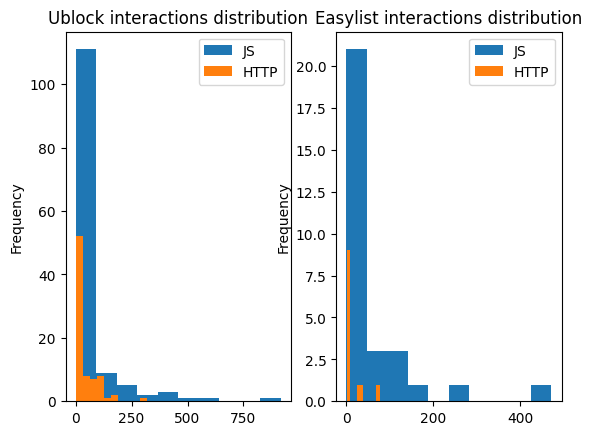

In [29]:
print("Ublock Events ")
print(ublock_interactions.js_counts.describe())
print(ublock_interactions.http_counts.describe())

print('------------')
print("Easylist")
print(easylist_interactions.js_counts.describe())
print(easylist_interactions.http_counts.describe())

plt.subplot(1,2,1)
ublock_interactions.js_counts.plot.hist(label="JS")
ublock_interactions.http_counts.plot.hist(label="HTTP")
plt.legend()
plt.title("Ublock interactions distribution")

plt.subplot(1,2,2)
easylist_interactions.js_counts.plot.hist(label="JS")
easylist_interactions.http_counts.plot.hist(label="HTTP")
plt.legend()
plt.title("Easylist interactions distribution")

## Graph extraction

In [2]:
def extract_interaction_features(db_path, exp_path, i):
    with Database(db_path, exp_path) as database:
        issues = database.sites_visits()
        issue = issues.iloc[i]
        
        (
            *_,
            fixed_to_broken_diff,
            fixed_to_broken_nodes,
            fixed_to_broken_edges,
        ) = features.process_differential_experiment(
            issue.browser_id_u,
            (issue.visit_id_a, issue.visit_id_b),
            database,
            issue.site_url,
            None,
        )
        
        print(f"len(fixed_to_broken_edges)={len(fixed_to_broken_edges)}")
        print(f"len(fixed_to_broken_edges)={len(fixed_to_broken_edges)}")
        
extract_interaction_features(EASYLIST.DB_PATH, EASYLIST.EXP_PATH, 10)

interactions= 3
df_javascript= 5
df_responses= 9
                                                 src     value  \
0                                2023-05-28 18:24:15  ["root"]   
1  https://api-spec.shlink.io/assets/index-72cff7...  ["root"]   

                            dst  type  count  
0  424898209=1637344654002427=3    15      1  
1  424898209=1637344654002427=3    14      1  
interactions= 3
df_javascript= 5
df_responses= 9
                                                 src     value  \
0                                2023-05-28 18:24:44  ["root"]   
1  https://api-spec.shlink.io/assets/index-72cff7...  ["root"]   

                            dst  type  count  
0  424898209=8766188377747054=3    15      1  
1  424898209=8766188377747054=3    14      1  
len(fixed_to_broken_edges)=0
len(fixed_to_broken_edges)=0


# Running Time

In [3]:
import pandas as pd
extract_stats1 = pd.read_csv("features-out/adguard/adguard-21/stats-extract.csv")
extract_stats2 = pd.read_csv("features-out/adguard/adguard-22/stats-extract.csv")
extract_stats3 = pd.read_csv("features-out/adguard/adguard-23/stats-extract.csv")

extract_stats = pd.concat([extract_stats1, extract_stats2, extract_stats3], axis=0, ignore_index=True)
extract_stats.to_csv("features-out/adguard/adguard-21-23/stats-extract.csv", index=False)

features_stats1 = pd.read_csv("features-out/adguard/adguard-21/stats-features.csv")
features_stats2 = pd.read_csv("features-out/adguard/adguard-22/stats-features.csv")
features_stats3 = pd.read_csv("features-out/adguard/adguard-23/stats-features.csv")

features_stats = pd.concat([features_stats1, features_stats2, features_stats3], axis=0, ignore_index=True)
features_stats.to_csv("features-out/adguard/adguard-21-23/stats-features.csv", index=False)


In [17]:
extract_stats = pd.read_csv("features-out/adguard/adguard-21-23/stats-extract.csv")
features_stats = pd.read_csv("features-out/adguard/adguard-21-23/stats-features.csv")

In [11]:
build_graph_durations = extract_stats[extract_stats['function'].apply(lambda x: 'label_alterations' in x)]

print("Mean build graph duration: ", build_graph_durations['time'].mean())
print("std build graph duration: ", build_graph_durations['time'].std())

Mean build graph duration:  0.06726831759145119
std build graph duration:  0.07757420790429718


In [19]:
print("Mean features duration: ", (features_stats['time'] / features_stats['n_issues']).mean())
print("Mean features duration: ", (features_stats['time'] / features_stats['n_issues']).std())

Mean features duration:  1.2905608347712507
Mean features duration:  3.10814852416814
